<a href="https://colab.research.google.com/github/ray-hsiehjy/Heart-disease-risk/blob/master/heart_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease dataset from [UCI repository](http://archive.ics.uci.edu/ml/datasets/Heart+Disease)

- Use random forest to identify risk metrics that most relevant to heart diseases


In [1]:
# Download data from UCI repository
!wget --no-verbose http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

# install shap for shap value analysis
!pip install shap -q

2019-09-30 19:12:03 URL:http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data [18461/18461] -> "processed.cleveland.data.2" [1]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from subprocess import run
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import shap

%matplotlib inline

# Attribute and Target Information:

## Attributes:

Numeric_linear
- age: age in years
- ca: number of major vessels (0-3) colored by Fluoroscopy 

Numeric_normal
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- thalach: maximum heart rate achieved
- oldpeak = ST depression induced by exercise relative to rest

categorical
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- exang: exercise induced angina (1 = yes; 0 = no)
- slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

## Target
- Numeric: 0, 1, 2, 3, 4; 
- 0 being no condition presence == healthy
- 1 through 4 are combined == diseased
- ouput, thus, is either False (healthy) or True (diseased)

In [3]:
header = [
    "age", 
    "sex", 
    "chest_pain", 
    "rest_bps", 
    "chol", 
    "fastingBS_high", 
    "rest_ecg", 
    "max_HR", 
    "ex_ang", 
    "oldpeak", 
    "slope_direction", 
    "num_vessel_colored", 
    "thalassemia", 
    "target"
]

df = pd.read_csv("/content/processed.cleveland.data", header=None, names=header)

# instead of 0 to 4, collapse all diseased states (1-4) to the same group
# 0 == health, 1 == diseased
df["target"] = (df["target"] > 0)#.replace({False:"healthy", True:"diseased"})

print(f"Data shape {df.shape}: {df.shape[0]} samples, each with {df.shape[1]-1} features. Last column is label.\n")
print(f"Output label is either True for diseased subject or False for healthy subject\n")
df.head()

Data shape (303, 14): 303 samples, each with 13 features. Last column is label.

Output label is either True for diseased subject or False for healthy subject



,age,sex,chest_pain,rest_bps,chol,fastingBS_high,rest_ecg,max_HR,ex_ang,oldpeak,slope_direction,num_vessel_colored,thalassemia,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,True
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False


# Prepare data for random forest classifier
- Check datatypes and missing values
- Convert categorical data to one-hot
- Split train-test sets

## Check datatypes

In [4]:
pd.DataFrame({"NaN":df.isna().sum(), "datatype":df.dtypes})

,NaN,datatype
age,0,float64
sex,0,float64
chest_pain,0,float64
rest_bps,0,float64
chol,0,float64
fastingBS_high,0,float64
rest_ecg,0,float64
max_HR,0,float64
ex_ang,0,float64
oldpeak,0,float64


## Handle missing values and fix datatypes

In [5]:
print(f"Unique values in:\nnum_vessel_colored = {df['num_vessel_colored'].unique()}\nthalassemia = {df['thalassemia'].unique()}")

Unique values in:
num_vessel_colored = ['0.0' '3.0' '2.0' '1.0' '?']
thalassemia = ['6.0' '3.0' '7.0' '?']


In [6]:
# there are 4 "?" in column num_vessel_colored and 2 "?" in column thal
df["num_vessel_colored"].replace("?", np.nan, inplace=True)
df["thalassemia"].replace("?", np.nan, inplace=True)

print(f"After replacing '?' with np.nan:\nnum_vessel_colored: {df['num_vessel_colored'].unique()}, thalassemia: {df['thalassemia'].unique()}")

df["num_vessel_colored"] = df["num_vessel_colored"].astype("float")
df["thalassemia"] = df["thalassemia"].astype("float")

# since there are not many samples with Nan, it's easier just dropping them
# other ways incluing using mean, median, searching for values using proximity matrix and etc
df.dropna(axis=0, inplace=True)

print(f"Data shape after dropping samples with missing values: {df.shape}")

After replacing '?' with np.nan:
num_vessel_colored: ['0.0' '3.0' '2.0' '1.0' nan], thalassemia: ['6.0' '3.0' '7.0' nan]
Data shape after dropping samples with missing values: (297, 14)


## Convert categorical data to one-hot (sparse)
- non-ordinal data need to be put in one-hot to avoid artifacts.
- For example, slope_direction is either up (1), down(3), or flat(2). They are not ordinal by nature, but encoding in numbers give the elusion that down > flat > up, which does not make biological or any real-world sense. 


In [7]:
cat_features = ["sex", "chest_pain","fastingBS_high", "rest_ecg", "ex_ang", "slope_direction", "thalassemia"]

hashes = [
    # sex_hash
    {0:"female", 1:"male"},    
    # cp_hash
    {1: "typical_angina", 2: "atypical_angina", 3: "non-anginal_pain", 4: "asymptomatic"},
    # fbs_hash
    {0:"no", 1:"yes"},
    # restecg_hash
    {0: "normal", 1: "ST-T_abnormal", 2: "LV_hypertrophy"},
    # exang_hash
    {0:"no", 1:"yes"},
    # slope_hash
    {1: "upsloping", 2: "flat", 3: "downsloping"},
    # thal_hash
    {3:"normal", 6:"fixed_defect", 7:"reversable_defect"}
]

# Converting numbers back to string is important because pandas get_dummies function only acts on object columns and not boolean or numeric columns
# Direct conversion with astype() will work, but it's not very human readable when it comes to model explanation
for f, h in zip(cat_features, hashes):
    df[f].replace(h, inplace=True)
    
print(df.dtypes)
df.head()

age                   float64
sex                    object
chest_pain             object
rest_bps              float64
chol                  float64
fastingBS_high         object
rest_ecg               object
max_HR                float64
ex_ang                 object
oldpeak               float64
slope_direction        object
num_vessel_colored    float64
thalassemia            object
target                   bool
dtype: object


,age,sex,chest_pain,rest_bps,chol,fastingBS_high,rest_ecg,max_HR,ex_ang,oldpeak,slope_direction,num_vessel_colored,thalassemia,target
0,63.0,male,typical_angina,145.0,233.0,yes,LV_hypertrophy,150.0,no,2.3,downsloping,0.0,fixed_defect,False
1,67.0,male,asymptomatic,160.0,286.0,no,LV_hypertrophy,108.0,yes,1.5,flat,3.0,normal,True
2,67.0,male,asymptomatic,120.0,229.0,no,LV_hypertrophy,129.0,yes,2.6,flat,2.0,reversable_defect,True
3,37.0,male,non-anginal_pain,130.0,250.0,no,normal,187.0,no,3.5,downsloping,0.0,normal,False
4,41.0,female,atypical_angina,130.0,204.0,no,LV_hypertrophy,172.0,no,1.4,upsloping,0.0,normal,False


In [8]:
# Get dummy data (one-hot) data
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head()

,age,rest_bps,chol,max_HR,oldpeak,num_vessel_colored,target,sex_male,chest_pain_atypical_angina,chest_pain_non-anginal_pain,chest_pain_typical_angina,fastingBS_high_yes,rest_ecg_ST-T_abnormal,rest_ecg_normal,ex_ang_yes,slope_direction_flat,slope_direction_upsloping,thalassemia_normal,thalassemia_reversable_defect
0,63.0,145.0,233.0,150.0,2.3,0.0,False,1,0,0,1,1,0,0,0,0,0,0,0
1,67.0,160.0,286.0,108.0,1.5,3.0,True,1,0,0,0,0,0,0,1,1,0,1,0
2,67.0,120.0,229.0,129.0,2.6,2.0,True,1,0,0,0,0,0,0,1,1,0,0,1
3,37.0,130.0,250.0,187.0,3.5,0.0,False,1,0,1,0,0,0,1,0,0,0,1,0
4,41.0,130.0,204.0,172.0,1.4,0.0,False,0,1,0,0,0,0,0,0,0,1,1,0


## Split train and test data

In [9]:
# randomly allocate 20% of samples to test set
train_X, test_X, train_y, test_y = train_test_split(
    df_dummy.drop("target", axis=1), 
    df_dummy["target"],
    test_size=0.2,
    random_state=13
)

print(f"train_X shape {train_X.shape}")
print(f"test_X shape {test_X.shape}")
print(f"train_y shape {train_y.shape}")
print(f"test_y shape {test_y.shape}")

train_X shape (237, 18)
test_X shape (60, 18)
train_y shape (237,)
test_y shape (60,)


# Random forest model

## Create model and fit with training data

In [0]:
RF = RandomForestClassifier(
    # builing 100 decision trees
    n_estimators=100, 
    # using gini impurity when building trees
    criterion="gini",
    max_depth=None,
    # internal nodes less than 5 samples will turn into a leaf
    min_samples_split=5,
    bootstrap=True,
    random_state=17
)

In [28]:
# fit with training data
RF.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

## Confusion matrix

In [51]:
pred = RF.predict(test_X)
pred_prob = RF.predict_proba(test_X)[:, 1]
report = classification_report(test_y, pred)

confusion = confusion_matrix(test_y, pred).T
confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == diseased\n")
print(report)
confusion

False == healthy; True == diseased

              precision    recall  f1-score   support

       False       0.94      0.86      0.90        35
        True       0.82      0.92      0.87        25

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60



,health,diseased
pred_health,30,2
pred_diseased,5,23


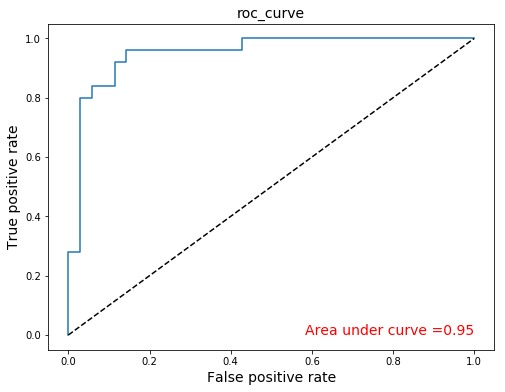

In [71]:
fpr, tpr, thresholds = roc_curve(test_y, pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot((0,1), (0,1), linestyle="--", color="k")
plt.xlabel("False positive rate", size=14)
plt.ylabel("True positive rate", size=14)
plt.title("roc_curve", size=14)
plt.text(1, 0, f"Area under curve ={auc(fpr, tpr):.2f}", size=14, ha="right", color="r")
plt.show()

## Feature importance

Top 5 factors: ['num_vessel_colored' 'thalassemia_normal' 'max_HR' 'oldpeak'
 'thalassemia_reversable_defect']



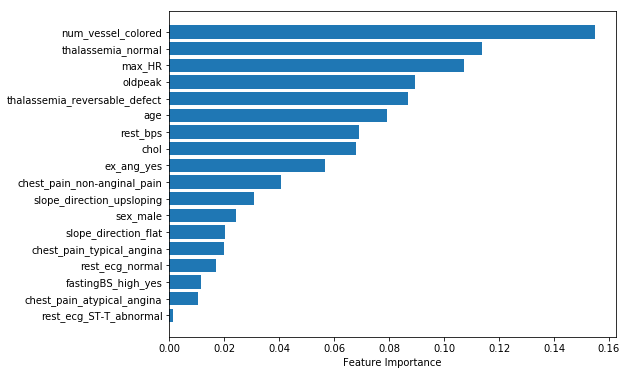

In [73]:
features = [c for c in train_X.columns]
importance = RF.feature_importances_

imp = pd.Series(data=importance, index=features).sort_values(ascending=True)
print(f"Top 5 factors: {imp[::-1].index[:5].values}\n")

plt.figure(figsize=(8, 6))
plt.barh(imp.index, imp)
plt.xlabel("Feature Importance")
plt.show()

## Visualize a random tree in the forest

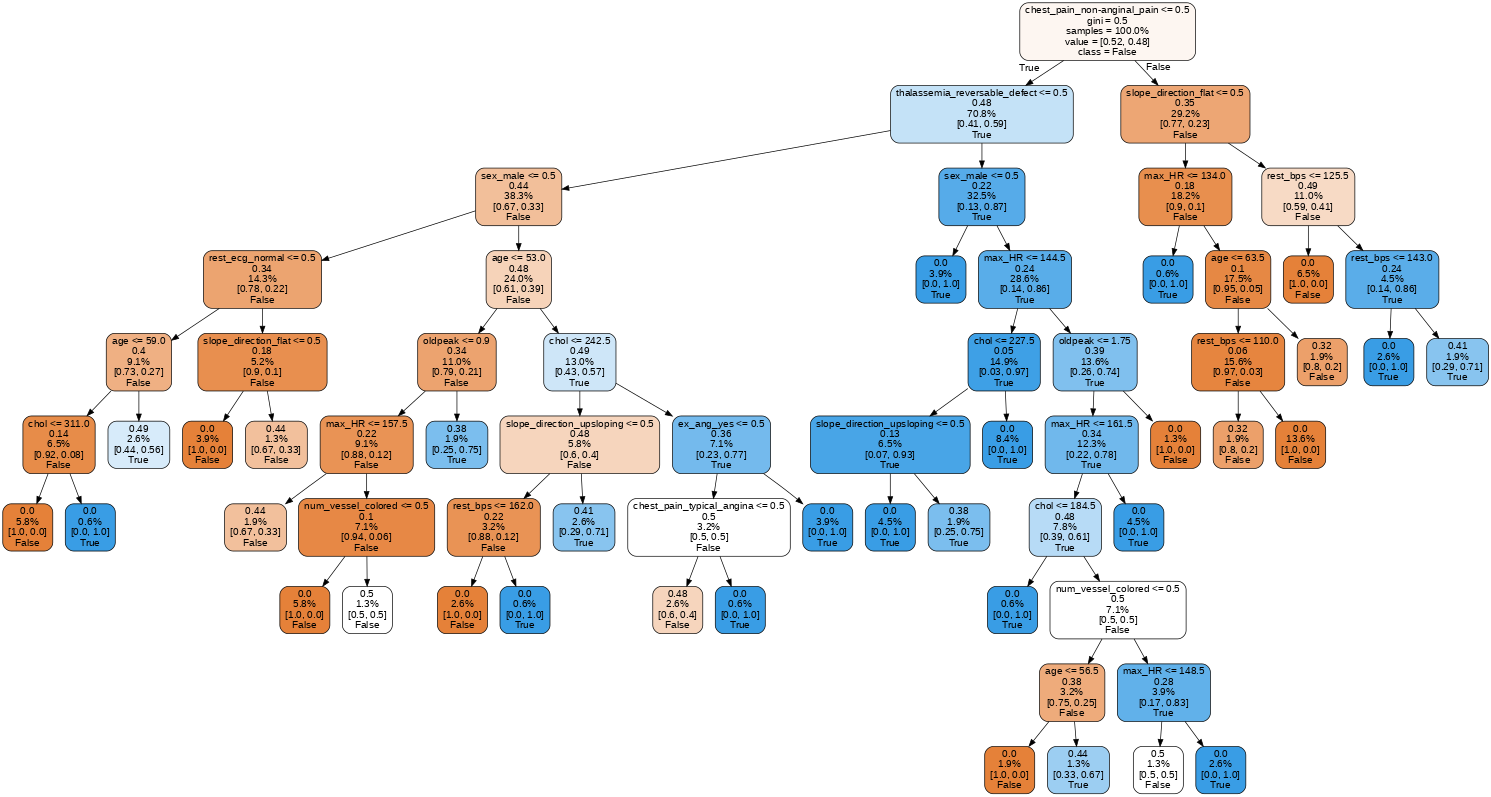

In [87]:
tree_index = 0 # random int from 0-99
estimator = RF.estimators_[0]
tree = export_graphviz(
    estimator, 
    out_file="tree.dot", 
    feature_names = features,
    class_names = train_y.astype("str"),
    rounded = True, proportion = True, 
    label='root',
    precision = 2, filled = True)

run(["dot", "-Tpng", "tree.dot", "-o", "tree.png", "-Gdpi=50"])
Image(filename = 'tree.png', retina=True)

# Random foreset with SHAP explainer

## Feature importance (using SHAP values)
- Feature importance prediction is mostly consistant with the outputs from feature\_importance_ function
- SHAP values help interpret how individual feature value affects the predection on a given sample



Positive impact == increase chance for True predictin (aka diseased)
Negative impact == increase chance for False predictin (aka healthy)

Feature importance prediction is mostly consistant with the outputs from feature_importance_ function



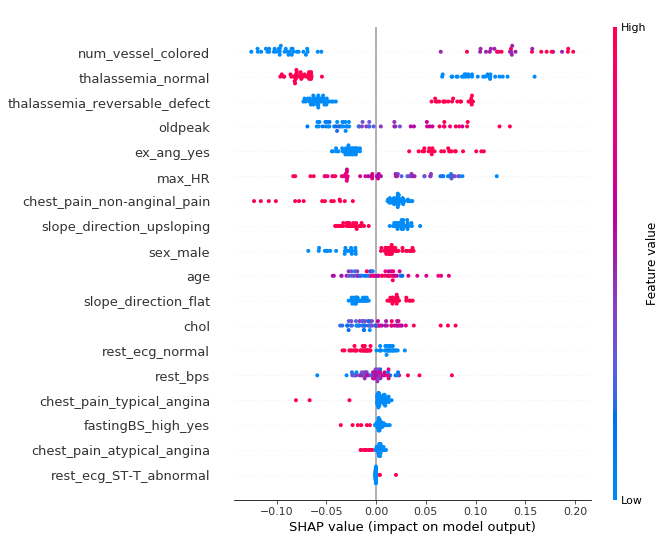

In [76]:
print("Positive impact == increase chance for True predictin (aka diseased)")
print("Negative impact == increase chance for False predictin (aka healthy)\n")

explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values[1], test_X)

## Visualize prediction for individual subject

In [77]:
# random select a subject from the test dataset
subject_index = np.random.randint(0, len(test_X), size=1)
print (f"Showing subject index {subject_index} in the test dataset")
print (f"Model prediects subject {subject_index} has heart disease = {RF.predict(test_X.values[subject_index])}")
print(f"Label y for subject {subject_index} has heart disease = {test_y.values[subject_index]}")

subject = test_X.iloc[subject_index,:]
shap_values_subject = explainer.shap_values(subject)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][subject_index,:], features=subject)

Showing subject index [7] in the test dataset
Model prediects subject [7] has heart disease = [False]
Label y for subject [7] has heart disease = [False]
